In [1]:
import numpy as np
import pandas as pd

In [2]:
data = pd.read_csv('../input/anime-recommendations-database/anime.csv')
data = data.dropna()
data

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
...,...,...,...,...,...,...,...
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211
12290,5543,Under World,Hentai,OVA,1,4.28,183
12291,5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175


# Анализ жанров

Чтобы определить, что смотрят нынче анимешники, сначала вытащим все жанры аниме

In [3]:
dirty_genre_list = list(set(list(data.genre)))
genre_list =list(set([g for x in dirty_genre_list for g in x.split(', ')]))
pd.Series(genre_list)

0            Hentai
1            Seinen
2         Shoujo Ai
3            Shoujo
4           Romance
5      Supernatural
6       Super Power
7         Adventure
8        Historical
9             Harem
10    Psychological
11            Space
12           Police
13             Yuri
14             Yaoi
15          Vampire
16         Military
17           Sci-Fi
18             Cars
19           Parody
20            Drama
21           Sports
22             Game
23           School
24            Ecchi
25            Josei
26            Music
27          Samurai
28            Mecha
29            Magic
30           Demons
31         Dementia
32             Kids
33           Action
34          Shounen
35           Horror
36       Shounen Ai
37          Mystery
38    Slice of Life
39         Thriller
40     Martial Arts
41           Comedy
42          Fantasy
dtype: object

Теперь проанализируем, сколько фильмов в каждом жанре

In [4]:
columns=['Жанр', 'Число фильмов']
stats_df = pd.DataFrame(columns=columns)
stats_df['Жанр'] = genre_list
stats_df['Число фильмов'] = 0

for g in list(data.genre):
    for genre in g.split(', '):
        stats_df.loc[stats_df['Жанр'] == genre, 'Число фильмов'] += 1
    
stats_df = stats_df.sort_values(by='Число фильмов', ascending=False)

In [5]:
stats_df

,Жанр,Число фильмов
41,Comedy,4575
33,Action,2768
7,Adventure,2316
42,Fantasy,2242
17,Sci-Fi,2036
20,Drama,1977
34,Shounen,1684
32,Kids,1598
4,Romance,1437
38,Slice of Life,1204


<AxesSubplot:xlabel='Жанр'>

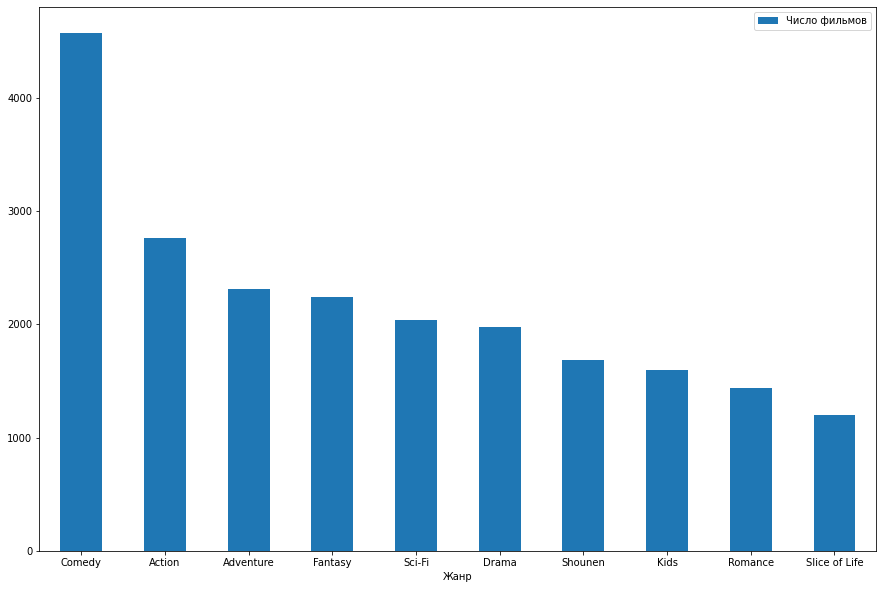

In [6]:
stats_df.set_index('Жанр').head(10).plot(kind='bar', figsize=(15, 10), rot=0)